# Sentiment analysis project: emotion detection in song lyrics

Import libraries and setting notebook

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import make_classification

from nltk.tokenize.treebank import TreebankWordDetokenizer

from matplotlib import pyplot as plt

from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from numpy import mean
from numpy import std

from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import chi2_contingency

import easygui as eg

In [2]:
pd.options.mode.chained_assignment = None

# 1. Preprocessing:

Import datasets:

In [3]:
anger = pd.read_csv("dataset/anger_train.txt", delimiter = "\t", header = None)
fear = pd.read_csv("dataset/fear_train.txt", delimiter = "\t", header = None)
joy = pd.read_csv("dataset/joy_train.txt", delimiter = "\t", header = None)
sadness = pd.read_csv("dataset/sadness_train.txt", delimiter = "\t", header = None)

Create some functions for text pre-processing:
- rename columns of dataframe;
- categorize the emotions;
- remove punctuations and twitter's features;
- filter out non-english words;
- perform lemmatization.
- remove useless information from song's lyrics.

In [4]:
#Create a function to rename columns of dataframe
def rename_columns(dataframe):
    dataframe.columns = ["code", "tweet", "sentiment", "intensity"]

#Create a function to categorize the intensity of the emotion
def categorize(df, column = "intensity", threshold = 0.55):
    df.loc[df[column]  <= threshold, column] = 0
    df.loc[df[column] > threshold, column] = 1
    
# remove non-english words:
def english_words(text):
    words = set(nltk.corpus.words.words())
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    
#Create a function to clean the tweets
def cleanTweets(text):
    text = re.sub(r'(@[A-Za-z0-9?_?]+)','', text) #removes @mentions
    text = re.sub(r'#','',text) #removes "#""
    text = re.sub(r'RT[\s]+', '', text) #removes retweet
    text = re.sub(r'http?:\/\/\S+' , '', text) #removes hyperlink
    text = re.sub('[^\w\s]',' ', text) #Remove punctuation
    text = re.sub('\s+', ' ', text) #Remove double spaces
    text = re.sub(r'\d+','', text) #Remove number
        
    return text

#Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [TreebankWordDetokenizer().detokenize(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))]

# Python program to convert a list to string
def listToString(s): 
    str1 = ""   # initialize an empty string
    for ele in s: 
        str1 += ele  # traverse in the string 
    return str1 

# Remove useless information from song lyrics
def remove_song_info(text):
    def remove_text_between_parens(text):
        n = 1  # run at least once
        while n:
            text, n = re.subn(r'\([^()]*\)', '', text)  # remove non-nested/flat balanced parts
        return text
    def remove_parens(text):
        text = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)
        return text
    return(remove_parens(remove_text_between_parens(text)))

In [5]:
#rename columns: 
dataframes = [anger, fear, joy, sadness]
for df in dataframes:
    rename_columns(df) 

Remove some noise: exclude from the analysis the intermediate level of emotions.

In [6]:
anger = anger[~anger['intensity'].between(0.35, 0.65)]
fear = fear[~fear['intensity'].between(0.35, 0.65)]
joy = joy[~joy['intensity'].between(0.35, 0.65)]
sadness = sadness[~sadness['intensity'].between(0.35, 0.65)]

Apply cleaning function to tweets:

In [7]:
#Stopword list
stop = set(pd.read_csv("dataset/stopwords.txt", header = None)[0].tolist())

#For each of the four dataset apply the preprocessing
dataframes = [anger, fear, joy, sadness]
for df in dataframes:
    categorize(df)
    df["tweet_cleaned"] = df["tweet"].apply(english_words)
    df["tweet_cleaned"] = df["tweet"].apply(cleanTweets)
    df["tweet_cleaned"] = df["tweet_cleaned"].str.lower()
    df["tweet_cleaned"] = df["tweet_cleaned"].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
    df["tweet_cleaned"] = df["tweet_cleaned"].apply(lemmatize_text)
    df["tweet_cleaned"] = df["tweet_cleaned"].apply(listToString)

In [8]:
anger_shuffle = anger.sample(frac = 1, random_state = 123)
fear_shuffle = fear.sample(frac = 1, random_state = 123)
joy_shuffle = joy.sample(frac = 1, random_state = 123)
sadness_shuffle = sadness.sample(frac = 1, random_state = 123)

# 2. Lyrics webscraping from genius lyrics website
### Creation of a dataset containing lyrics from artists of three genres: rock, pop, hip-hop, electronic.

Create a function to retrieve useful information from each song: title, lyrics, artist.

In [9]:
import lyricsgenius as genius

def search_data(query,n,access_token):
    
    api = genius.Genius(access_token)

    list_lyrics = []
    list_title = []
    list_artist = []

    artist = api.search_artist(query,max_songs=n,sort='popularity')
    songs = artist.songs
    for song in songs:
        list_lyrics.append(song.lyrics)
        list_title.append(song.title)
        list_artist.append(song.artist)
        
    df = pd.DataFrame({'artist':list_artist,'title':list_title, 'lyrics':list_lyrics})
    
    return df

For each genre select 20 artists and for each artist 6 songs.
The dataset is ready and this part can be omitted, it requires long time of execution.

In [10]:
#songs_per_artist = 6

#list_of_artist = pd.read_csv("dataset/artists.txt", header = None)[0].tolist()

#access_token = "pXIinxO4jif-OoFpYdZuuLnQSTpve1ktX2tZXARh8xvyBGlUy7gzMTZrbSPClPQk"

#artists = list_of_artist

#df_lyrics = pd.DataFrame(columns = ['artist','title', 'lyrics'])

#for artist in artists:
    
#    while True:
#        try:
#            df_lyrics = df_lyrics.append(search_data(artist, songs_per_artist, access_token))
#            break
#        except:
#            pass

In [11]:
#artist_per_genre = 20

#from itertools import repeat
#genres = ["Rock", "Pop", "Hip-Hop", "Electronic"]
#genre_array = []

#for genre in genres:
    #genre_array.extend(repeat(genre, songs_per_artist*artist_per_genre))

#df_lyrics["genre"] = genre_array
#df_lyrics = df_lyrics.reset_index()
#df_lyrics = df_lyrics.drop([df_lyrics.columns[0]], axis='columns')

In [12]:
#df_lyrics.to_pickle("df_lyrics_long")

In [13]:
df_lyrics = pd.read_pickle('dataset/df_lyrics_long')

# 3. Create a model to predict emotions using Wassa-2017 training set.

### Training logistic regression by using k-fold cross validation to validate the model

Set seed for the reproducibility of the experiment:

In [14]:
seed_value = 123
tf.random.set_seed(seed_value)

Perform vectorization of the training sets:

In [15]:
cv = CountVectorizer(binary = True, analyzer = "word")

anger_vec = cv.fit_transform(anger_shuffle.tweet_cleaned)
fear_vec = cv.fit_transform(fear_shuffle.tweet_cleaned)
joy_vec = cv.fit_transform(joy_shuffle.tweet_cleaned)
sadness_vec = cv.fit_transform(sadness_shuffle.tweet_cleaned)

Apply logistic regression and set the cross validation by considering 5 folds:

In [16]:
#vectors with the vectorized training set and their labels
vec = [anger_vec, fear_vec, joy_vec, sadness_vec]
df_shuffle = [anger_shuffle, fear_shuffle, joy_shuffle, sadness_shuffle]

#cross validation settings:
cross_v = KFold(n_splits = 5, random_state = 1, shuffle = True)

model = LogisticRegression()

scores_list = []

for i in range(0, len(vec)):
    X = vec[i]
    y = df_shuffle[i].intensity
    scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cross_v, n_jobs = -1)

    scores_list.append(scores)

scores_list

[array([0.85      , 0.73333333, 0.78333333, 0.75      , 0.84745763]),
 array([0.80952381, 0.79047619, 0.82857143, 0.81730769, 0.875     ]),
 array([0.74390244, 0.77777778, 0.82716049, 0.74074074, 0.81481481]),
 array([0.87012987, 0.72368421, 0.86842105, 0.81578947, 0.78947368])]

Plot the results of cross validation:

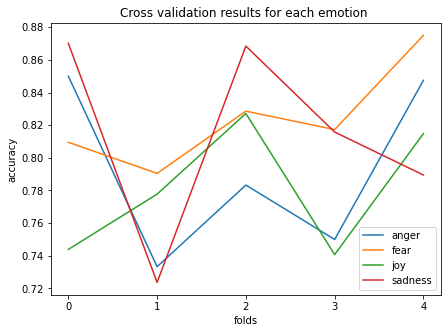

In [17]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(scores_list[0], label = "anger")
plt.plot(scores_list[1], label = "fear")
plt.plot(scores_list[2], label = "joy")
plt.plot(scores_list[3], label = "sadness")
plt.xlabel('folds')
plt.ylabel('accuracy')
plt.xticks(range(0,5))
plt.title('Cross validation results for each emotion ')
plt.legend()

Create avg_model function to perform the average of the cross validation results on each training set and apply it:

In [18]:
from statistics import mean
def avg_model(list_of_arrays):
    
    avg_list = []
    for l in list_of_arrays:
        avg = mean(l)
        avg_list.append(round(avg, 2))
    
    return(avg_list)

In [19]:
avg_logistic = avg_model(scores_list)
avg_logistic

[0.79, 0.82, 0.78, 0.81]

In [20]:
data = {'Logistic_regression':['Anger_model', 'Fear_model', 'Joy_model', 'Sadness_model'],
        'Avg_cross_validation': avg_logistic}

results = pd.DataFrame(data)
results

Logistic_regression  Avg_cross_validation
0         Anger_model                  0.79
1          Fear_model                  0.82
2           Joy_model                  0.78
3       Sadness_model                  0.81

### Create a function to perform lyrics preprocessing

In [21]:
def clean_lyrics(df, column):
    stop = set(pd.read_csv("dataset/stopwords.txt", header = None)[0].tolist())
    
    df[column] = df[column].apply(remove_song_info)
    df[column] = df[column].str.lower()
    df[column] = df[column].apply(cleanTweets)
    df[column] = df[column].apply(english_words)
    df[column] = df[column].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop))
    df[column] = df[column].apply(lemmatize_text)
    df[column] = df[column].apply(listToString)

### Create a function to obtain just the chorus from the lyrics

In [22]:
def refrain(df):
    word = "Chorus"
    for i in range(0, len(df)):
        text = df.lyrics[i]
        try:
            if word in text: 
                substring = text.split("Chorus")[1]
                substring = substring.split("Verse")[0]
            else: 
                substring = text.split("Verse 1")[1]
                substring = substring.split("Verse 2")[0] 
                
        except IndexError:
            substring = text.split()[:30]
        
        df["chorus"][i] = str(substring)

### Import the lyrics dataset previously created, clean it and extract the chorus

In [23]:
pd.set_option('display.max_rows', None)
df_lyrics = pd.read_pickle('dataset/df_lyrics_long')
df_lyrics["chorus"] = "np.nan"

In [24]:
refrain(df_lyrics)
clean_lyrics(df_lyrics, "lyrics")
clean_lyrics(df_lyrics, "chorus")

In [25]:
df_lyrics[:10]

artist                        title  \
0        AC/DC                Back in Black   
1        AC/DC              Highway to Hell   
2        AC/DC                Thunderstruck   
3        AC/DC                       T.N.T.   
4        AC/DC  You Shook Me All Night Long   
5        AC/DC  Dirty Deeds Done Dirt Cheap   
6  The Beatles                    Let It Be   
7  The Beatles                    Yesterday   
8  The Beatles                Come Together   
9  The Beatles                     Hey Jude   

                                              lyrics genre  \
0  black hit sack glad loose noose hanging sky fo...  Rock   
1  living easy living season ticket ride leave st...  Rock   
2  thunder thunder thunder thunder thunder thunde...  Rock   
3  ride sunset color screen left gun knife start ...  Rock   
4  fast machine motor clean damn woman sightless ...  Rock   
5  trouble school head blue graduate bed pick pho...  Rock   
6  time trouble mother mary speaking wisdom hour ...  Rock   
7  yesterday stay yesterday suddenly shadow hangi...  Rock   
8  shoot shoot shoot shoot flat slowly eyeball ho...  Rock   
9  bad sad song remember heart start afraid minut...  Rock   

                                     chorus  
0                               black black  
1           highway highway highway highway  
2                             thunderstruck  
3                     gun knife start fight  
4                   shook night shook night  
5                           lead life crime  
6                            whisper wisdom  
7                           wrong yesterday  
8                   shoot shoot shoot shoot  
9  feel pain refrain carry fool cool colder

## Application of the fitted logistic regression on the lyrics

In [26]:
anger_vec = cv.fit_transform(anger_shuffle.tweet_cleaned)
fear_vec = cv.fit_transform(fear_shuffle.tweet_cleaned)
joy_vec = cv.fit_transform(joy_shuffle.tweet_cleaned)
sadness_vec = cv.fit_transform(sadness_shuffle.tweet_cleaned)

list_of_vec = [anger_vec, fear_vec, joy_vec, sadness_vec]
list_of_shuffle = [anger_shuffle, fear_shuffle,joy_shuffle,sadness_shuffle]

df_col = ["anger", "fear", "joy", "sadness"]

for i in range(0, len(list_of_vec)):
    lr = LogisticRegression()
    
    vec = cv.fit_transform(list_of_shuffle[i].tweet_cleaned)
    X = vec
    y = list_of_shuffle[i].intensity
    lr.fit(X,y)
    
    X_lyrics = cv.transform(df_lyrics.lyrics)
    y_pred = lr.predict(X_lyrics)
    
    df_lyrics[df_col[i]] = y_pred

In [27]:
df_lyrics[:10]

artist                        title  \
0        AC/DC                Back in Black   
1        AC/DC              Highway to Hell   
2        AC/DC                Thunderstruck   
3        AC/DC                       T.N.T.   
4        AC/DC  You Shook Me All Night Long   
5        AC/DC  Dirty Deeds Done Dirt Cheap   
6  The Beatles                    Let It Be   
7  The Beatles                    Yesterday   
8  The Beatles                Come Together   
9  The Beatles                     Hey Jude   

                                              lyrics genre  \
0  black hit sack glad loose noose hanging sky fo...  Rock   
1  living easy living season ticket ride leave st...  Rock   
2  thunder thunder thunder thunder thunder thunde...  Rock   
3  ride sunset color screen left gun knife start ...  Rock   
4  fast machine motor clean damn woman sightless ...  Rock   
5  trouble school head blue graduate bed pick pho...  Rock   
6  time trouble mother mary speaking wisdom hour ...  Rock   
7  yesterday stay yesterday suddenly shadow hangi...  Rock   
8  shoot shoot shoot shoot flat slowly eyeball ho...  Rock   
9  bad sad song remember heart start afraid minut...  Rock   

                                     chorus  anger  fear  joy  sadness  
0                               black black    0.0   0.0  1.0      0.0  
1           highway highway highway highway    0.0   0.0  0.0      0.0  
2                             thunderstruck    1.0   1.0  1.0      0.0  
3                     gun knife start fight    0.0   0.0  0.0      1.0  
4                   shook night shook night    1.0   0.0  0.0      0.0  
5                           lead life crime    0.0   0.0  1.0      0.0  
6                            whisper wisdom    1.0   1.0  0.0      0.0  
7                           wrong yesterday    0.0   0.0  1.0      0.0  
8                   shoot shoot shoot shoot    1.0   1.0  0.0      1.0  
9  feel pain refrain carry fool cool colder    0.0   1.0  0.0      1.0

## Application of the fitted logistic regression on the chorus

In [28]:
df_col_uncertain = ["anger_ch", "fear_ch", "joy_ch", "sadness_ch"]

for i in range(0, len(list_of_vec)):
    lr = LogisticRegression()
    
    vec = cv.fit_transform(list_of_shuffle[i].tweet_cleaned)
    X = vec
    y = list_of_shuffle[i].intensity
    lr.fit(X,y)
    
    X_lyrics_chorus = cv.transform(df_lyrics.chorus)
    y_pred_chorus = lr.predict(X_lyrics_chorus)
    
    df_lyrics[df_col_uncertain[i]] = y_pred_chorus

In [29]:
df_lyrics[:10]

artist                        title  \
0        AC/DC                Back in Black   
1        AC/DC              Highway to Hell   
2        AC/DC                Thunderstruck   
3        AC/DC                       T.N.T.   
4        AC/DC  You Shook Me All Night Long   
5        AC/DC  Dirty Deeds Done Dirt Cheap   
6  The Beatles                    Let It Be   
7  The Beatles                    Yesterday   
8  The Beatles                Come Together   
9  The Beatles                     Hey Jude   

                                              lyrics genre  \
0  black hit sack glad loose noose hanging sky fo...  Rock   
1  living easy living season ticket ride leave st...  Rock   
2  thunder thunder thunder thunder thunder thunde...  Rock   
3  ride sunset color screen left gun knife start ...  Rock   
4  fast machine motor clean damn woman sightless ...  Rock   
5  trouble school head blue graduate bed pick pho...  Rock   
6  time trouble mother mary speaking wisdom hour ...  Rock   
7  yesterday stay yesterday suddenly shadow hangi...  Rock   
8  shoot shoot shoot shoot flat slowly eyeball ho...  Rock   
9  bad sad song remember heart start afraid minut...  Rock   

                                     chorus  anger  fear  joy  sadness  \
0                               black black    0.0   0.0  1.0      0.0   
1           highway highway highway highway    0.0   0.0  0.0      0.0   
2                             thunderstruck    1.0   1.0  1.0      0.0   
3                     gun knife start fight    0.0   0.0  0.0      1.0   
4                   shook night shook night    1.0   0.0  0.0      0.0   
5                           lead life crime    0.0   0.0  1.0      0.0   
6                            whisper wisdom    1.0   1.0  0.0      0.0   
7                           wrong yesterday    0.0   0.0  1.0      0.0   
8                   shoot shoot shoot shoot    1.0   1.0  0.0      1.0   
9  feel pain refrain carry fool cool colder    0.0   1.0  0.0      1.0   

   anger_ch  fear_ch  joy_ch  sadness_ch  
0       1.0      0.0     0.0         1.0  
1       0.0      0.0     0.0         0.0  
2       0.0      0.0     0.0         0.0  
3       0.0      0.0     0.0         1.0  
4       0.0      0.0     0.0         0.0  
5       0.0      0.0     0.0         1.0  
6       0.0      0.0     0.0         0.0  
7       0.0      0.0     0.0         0.0  
8       1.0      0.0     0.0         0.0  
9       1.0      1.0     0.0         1.0

Create two columns containing the sum of the emotion for each complete lyrics and for each chorus:

In [30]:
df_lyrics["sum_song"] = df_lyrics["anger"]+df_lyrics["fear"]+df_lyrics["joy"]+df_lyrics["sadness"]
df_lyrics["sum_ch"] = df_lyrics["anger_ch"]+df_lyrics["fear_ch"]+df_lyrics["joy_ch"]+df_lyrics["sadness_ch"]

In [31]:
emotions = ["anger", "fear", "joy", "sadness"]
for emo in emotions:
    print(sum(df_lyrics[emo]))

105.0
169.0
223.0
118.0


In [32]:
df_lyrics[:10]

artist                        title  \
0        AC/DC                Back in Black   
1        AC/DC              Highway to Hell   
2        AC/DC                Thunderstruck   
3        AC/DC                       T.N.T.   
4        AC/DC  You Shook Me All Night Long   
5        AC/DC  Dirty Deeds Done Dirt Cheap   
6  The Beatles                    Let It Be   
7  The Beatles                    Yesterday   
8  The Beatles                Come Together   
9  The Beatles                     Hey Jude   

                                              lyrics genre  \
0  black hit sack glad loose noose hanging sky fo...  Rock   
1  living easy living season ticket ride leave st...  Rock   
2  thunder thunder thunder thunder thunder thunde...  Rock   
3  ride sunset color screen left gun knife start ...  Rock   
4  fast machine motor clean damn woman sightless ...  Rock   
5  trouble school head blue graduate bed pick pho...  Rock   
6  time trouble mother mary speaking wisdom hour ...  Rock   
7  yesterday stay yesterday suddenly shadow hangi...  Rock   
8  shoot shoot shoot shoot flat slowly eyeball ho...  Rock   
9  bad sad song remember heart start afraid minut...  Rock   

                                     chorus  anger  fear  joy  sadness  \
0                               black black    0.0   0.0  1.0      0.0   
1           highway highway highway highway    0.0   0.0  0.0      0.0   
2                             thunderstruck    1.0   1.0  1.0      0.0   
3                     gun knife start fight    0.0   0.0  0.0      1.0   
4                   shook night shook night    1.0   0.0  0.0      0.0   
5                           lead life crime    0.0   0.0  1.0      0.0   
6                            whisper wisdom    1.0   1.0  0.0      0.0   
7                           wrong yesterday    0.0   0.0  1.0      0.0   
8                   shoot shoot shoot shoot    1.0   1.0  0.0      1.0   
9  feel pain refrain carry fool cool colder    0.0   1.0  0.0      1.0   

   anger_ch  fear_ch  joy_ch  sadness_ch  sum_song  sum_ch  
0       1.0      0.0     0.0         1.0       1.0     2.0  
1       0.0      0.0     0.0         0.0       0.0     0.0  
2       0.0      0.0     0.0         0.0       3.0     0.0  
3       0.0      0.0     0.0         1.0       1.0     1.0  
4       0.0      0.0     0.0         0.0       1.0     0.0  
5       0.0      0.0     0.0         1.0       1.0     1.0  
6       0.0      0.0     0.0         0.0       2.0     0.0  
7       0.0      0.0     0.0         0.0       1.0     0.0  
8       1.0      0.0     0.0         0.0       3.0     1.0  
9       1.0      1.0     0.0         1.0       2.0     3.0

Retrieve the number of songs for which:
- no emotions have been detected;
- more than 2 emotions have been detected.

In [33]:
len(df_lyrics[(df_lyrics["sum_song"] == 0)])

97

In [34]:
len(df_lyrics[(df_lyrics["sum_song"] >= 3)])

61

## 4. Interpretation of the results: combination of the emotion detected and analysis of correlation genre-emotion

### Assign emotion name for each song:
- For songs for which one only emotion has been detected, the assignment is easy and correspond to the emotion detected.
- For songs for which two emotions have been detected, Plutchik's wheel of emotions is applied to retrieve the emotion derived from their combination.

In [35]:
df_lyrics_defined = df_lyrics[df_lyrics.sum_song < 3]

df_lyrics_defined.loc[(df_lyrics_defined['anger'] ==  0) & (df_lyrics_defined['fear'] == 0) & (df_lyrics_defined['joy'] == 0) & (df_lyrics_defined['sadness'] == 0), 'emotion'] = "unknown"
df_lyrics_defined.loc[(df_lyrics_defined['anger'] ==  1), 'emotion'] = 'anger'
df_lyrics_defined.loc[(df_lyrics_defined['fear'] ==  1), 'emotion'] = 'fear'
df_lyrics_defined.loc[(df_lyrics_defined['joy'] ==  1), 'emotion'] = 'joy'
df_lyrics_defined.loc[(df_lyrics_defined['sadness'] ==  1), 'emotion'] = 'sadness'

df_lyrics_defined.loc[(df_lyrics_defined['anger'] ==  1) & (df_lyrics_defined['fear'] == 1), 'emotion'] = 'frozeness' 
df_lyrics_defined.loc[(df_lyrics_defined['anger'] ==  1) & (df_lyrics_defined['joy'] == 1), 'emotion'] = 'pride'
df_lyrics_defined.loc[(df_lyrics_defined['anger'] ==  1) & (df_lyrics_defined['sadness'] == 1), 'emotion'] = 'envy' 
df_lyrics_defined.loc[(df_lyrics_defined['fear'] ==  1) & (df_lyrics_defined['joy'] == 1), 'emotion'] = 'excitement'
df_lyrics_defined.loc[(df_lyrics_defined['fear'] ==  1) & (df_lyrics_defined['sadness'] == 1), 'emotion'] = 'despair'
df_lyrics_defined.loc[(df_lyrics_defined['joy'] ==  1) & (df_lyrics_defined['sadness'] == 1), 'emotion'] = 'bittersweetness'

In [36]:
df_lyrics_undefined = df_lyrics[df_lyrics.sum_song >= 3]

df_lyrics_undefined.loc[(df_lyrics_undefined['anger_ch'] ==  1), 'emotion'] = 'anger'
df_lyrics_undefined.loc[(df_lyrics_undefined['fear_ch'] ==  1), 'emotion'] = 'fear'
df_lyrics_undefined.loc[(df_lyrics_undefined['joy_ch'] ==  1), 'emotion'] = 'joy'
df_lyrics_undefined.loc[(df_lyrics_undefined['sadness_ch'] ==  1), 'emotion'] = 'sadness'

df_lyrics_undefined.loc[(df_lyrics_undefined['anger_ch'] ==  1) & (df_lyrics_undefined['fear_ch'] == 1), 'emotion'] = 'frozeness' 
df_lyrics_undefined.loc[(df_lyrics_undefined['anger_ch'] ==  1) & (df_lyrics_undefined['joy_ch'] == 1), 'emotion'] = 'pride'
df_lyrics_undefined.loc[(df_lyrics_undefined['anger_ch'] ==  1) & (df_lyrics_undefined['sadness_ch'] == 1), 'emotion'] = 'envy' 
df_lyrics_undefined.loc[(df_lyrics_undefined['fear_ch'] ==  1) & (df_lyrics_undefined['joy_ch'] == 1), 'emotion'] = 'excitement'
df_lyrics_undefined.loc[(df_lyrics_undefined['fear_ch'] ==  1) & (df_lyrics_undefined['sadness_ch'] == 1), 'emotion'] = 'despair'
df_lyrics_undefined.loc[(df_lyrics_undefined['joy_ch'] ==  1) & (df_lyrics_undefined['sadness_ch'] == 1), 'emotion'] = 'bittersweetness'

df_lyrics_undefined.loc[(df_lyrics_undefined['sum_ch'] >=  3), 'emotion'] = 'unknown' 
df_lyrics_undefined.loc[(df_lyrics_undefined['anger_ch'] ==  0) & (df_lyrics_undefined['fear_ch'] == 0) & (df_lyrics_undefined['joy_ch'] == 0) & (df_lyrics_undefined['sadness_ch'] == 0), 'emotion'] = "unknown"

In [37]:
df_lyrics_emotions = pd.concat([df_lyrics_defined, df_lyrics_undefined]).reset_index(drop=True)

In [38]:
df_lyrics_emotions[:10]

artist                        title  \
0        AC/DC                Back in Black   
1        AC/DC              Highway to Hell   
2        AC/DC                       T.N.T.   
3        AC/DC  You Shook Me All Night Long   
4        AC/DC  Dirty Deeds Done Dirt Cheap   
5  The Beatles                    Let It Be   
6  The Beatles                    Yesterday   
7  The Beatles                     Hey Jude   
8  The Beatles                    Something   
9  The Beatles           Here Comes the Sun   

                                              lyrics genre  \
0  black hit sack glad loose noose hanging sky fo...  Rock   
1  living easy living season ticket ride leave st...  Rock   
2  ride sunset color screen left gun knife start ...  Rock   
3  fast machine motor clean damn woman sightless ...  Rock   
4  trouble school head blue graduate bed pick pho...  Rock   
5  time trouble mother mary speaking wisdom hour ...  Rock   
6  yesterday stay yesterday suddenly shadow hangi...  Rock   
7  bad sad song remember heart start afraid minut...  Rock   
8  lover leave smile need lover style leave love ...  Rock   
9  sun da sun darling cold lonely winter darling ...  Rock   

                                     chorus  anger  fear  joy  sadness  \
0                               black black    0.0   0.0  1.0      0.0   
1           highway highway highway highway    0.0   0.0  0.0      0.0   
2                     gun knife start fight    0.0   0.0  0.0      1.0   
3                   shook night shook night    1.0   0.0  0.0      0.0   
4                           lead life crime    0.0   0.0  1.0      0.0   
5                            whisper wisdom    1.0   1.0  0.0      0.0   
6                           wrong yesterday    0.0   0.0  1.0      0.0   
7  feel pain refrain carry fool cool colder    0.0   1.0  0.0      1.0   
8                                     leave    0.0   0.0  1.0      0.0   
9                                sun da sun    0.0   1.0  1.0      0.0   

   anger_ch  fear_ch  joy_ch  sadness_ch  sum_song  sum_ch     emotion  
0       1.0      0.0     0.0         1.0       1.0     2.0         joy  
1       0.0      0.0     0.0         0.0       0.0     0.0     unknown  
2       0.0      0.0     0.0         1.0       1.0     1.0     sadness  
3       0.0      0.0     0.0         0.0       1.0     0.0       anger  
4       0.0      0.0     0.0         1.0       1.0     1.0         joy  
5       0.0      0.0     0.0         0.0       2.0     0.0   frozeness  
6       0.0      0.0     0.0         0.0       1.0     0.0         joy  
7       1.0      1.0     0.0         1.0       2.0     3.0     despair  
8       0.0      0.0     0.0         1.0       1.0     1.0         joy  
9       0.0      0.0     0.0         0.0       2.0     0.0  excitement

In [39]:
len(df_lyrics_emotions[(df_lyrics_emotions["emotion"] == "unknown")])

127

In [40]:
lyrics_emotions = df_lyrics_emotions[df_lyrics_emotions['emotion'] != "unknown"]

### Contingency table:

In [41]:
lyrics_crosstab = pd.crosstab(lyrics_emotions['genre'],
                              lyrics_emotions['emotion'],
                              margins = True)
                              #normalize = True).round(2)
    
observed = pd.crosstab(lyrics_emotions['genre'],
                              lyrics_emotions['emotion'])
                              #margins = True)
                              #normalize = True).round(2)

In [42]:
lyrics_crosstab

emotion     anger  bittersweetness  despair  envy  excitement  fear  \
genre                                                                 
Electronic     10                9        8     0           4     8   
Hip-Hop        14                3       10     1           6    12   
Pop             8                3        3     3           8     7   
Rock            8                5       12     4          12     6   
All            40               20       33     8          30    33   

emotion     frozeness  joy  pride  sadness  All  
genre                                            
Electronic          2   36      1        9   87  
Hip-Hop            10   22      4        1   83  
Pop                 3   48      0        8   91  
Rock                4   34      1        6   92  
All                19  140      6       24  353

### Create expected values table and distance from actual values

## Chi-square test:

In [43]:
stat, p, dof, expected = chi2_contingency(lyrics_crosstab)

In [44]:
# interpret p-value
alpha = 0.1
print("p value is " + str(round(p, 2)))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.05
Dependent (reject H0)


In [45]:
expected = np.outer(lyrics_crosstab["All"][0:4],lyrics_crosstab.loc["All",][0:10])/lyrics_crosstab.loc["All","All"]
expected = pd.DataFrame(expected)

expected.columns = lyrics_crosstab.columns.values[0:10]
expected.index = lyrics_crosstab.index.values[0:4]

In [46]:
round(expected,1)

anger  bittersweetness  despair  envy  excitement  fear  \
Electronic    9.9              4.9      8.1   2.0         7.4   8.1   
Hip-Hop       9.4              4.7      7.8   1.9         7.1   7.8   
Pop          10.3              5.2      8.5   2.1         7.7   8.5   
Rock         10.4              5.2      8.6   2.1         7.8   8.6   

            frozeness   joy  pride  sadness  
Electronic        4.7  34.5    1.5      5.9  
Hip-Hop           4.5  32.9    1.4      5.6  
Pop               4.9  36.1    1.5      6.2  
Rock              5.0  36.5    1.6      6.3

In [47]:
distance = round(observed - expected, 1)
distance

emotion     anger  bittersweetness  despair  envy  excitement  fear  \
genre                                                                 
Electronic    0.1              4.1     -0.1  -2.0        -3.4  -0.1   
Hip-Hop       4.6             -1.7      2.2  -0.9        -1.1   4.2   
Pop          -2.3             -2.2     -5.5   0.9         0.3  -1.5   
Rock         -2.4             -0.2      3.4   1.9         4.2  -2.6   

emotion     frozeness   joy  pride  sadness  
genre                                        
Electronic       -2.7   1.5   -0.5      3.1  
Hip-Hop           5.5 -10.9    2.6     -4.6  
Pop              -1.9  11.9   -1.5      1.8  
Rock             -1.0  -2.5   -0.6     -0.3

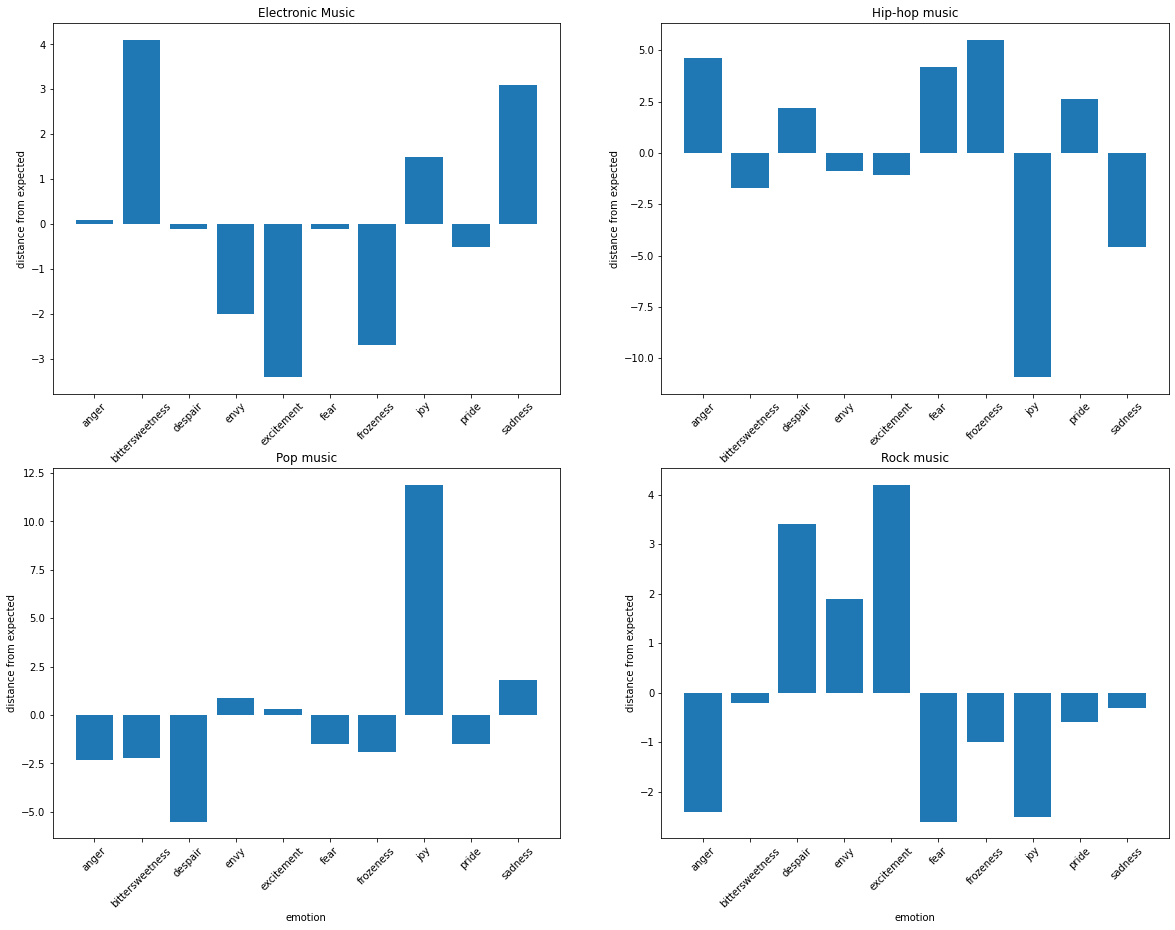

In [48]:
plt.rcParams['figure.figsize'] = [20, 15]

labels = ["anger", "bittersweetness", "despair", "envy", "excitement", "fear", "frozeness", "joy", "pride", "sadness"]

fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(labels, distance.loc["Electronic",])
axs[0, 0].set_title('Electronic Music')
axs[0, 1].bar(labels, distance.loc["Hip-Hop",])
axs[0, 1].set_title('Hip-hop music')
axs[1, 0].bar(labels, distance.loc["Pop",])
axs[1, 0].set_title('Pop music')
axs[1, 1].bar(labels, distance.loc["Rock",])
axs[1, 1].set_title('Rock music')


for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


for ax in axs.flat:
    ax.set(xlabel='emotion', ylabel='distance from expected')

for ax in axs.flat:
    ax.set(xlabel='emotion', ylabel='distance from expected')


## 5. Automatically create a playlist based on lyrics given user preferences about music genres and the user current mood.

Assign to the songs with unknown emotion the main emotion connected to the genre:

In [49]:
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Electronic") , ['anger', 'fear']] = 0
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Electronic") , ['joy', 'sadness']] = 1
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Electronic") , 'emotion'] = 'bittersweetness'

df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Hip-Hop") , ['joy', 'sadness']] = 0
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Hip-Hop") , ['anger', 'fear']] = 1
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Hip-Hop") , 'emotion'] = 'frozeness'

df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Pop") , ['anger', 'sadness', 'fear']] = 0
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Pop") , 'joy'] = 1                        
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Pop") , 'emotion'] = 'joy'
                   
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Rock") , ['sadness', 'anger']] = 0
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Rock") , ['fear', 'joy']] = 1
df_lyrics_emotions.loc[(df_lyrics_emotions['emotion'] ==  "unknown") & (df_lyrics_emotions['genre'] ==  "Rock") , 'emotion'] = 'excitement'

Creation of the playlist

In [50]:
question = "What is your favourite music genre?"
title = "Playlist Creation"
listOfOptions = ["Rock", "Pop", "Hip Hop", "Electronic"]

genre = eg.multchoicebox(question , title, listOfOptions)

In [51]:
genre

['Rock', 'Hip Hop']

In [52]:
question = "Which is your mood today? (you can choose more than one)"
title = "Today's feelings"
listOfOptions = ["anger", "fear", "joy", "sadness"]

feeling = eg.multchoicebox(question , title, listOfOptions)

In [53]:
feeling

['anger', 'joy']

Filter by genre selected

Definition of jaccard similarity

In [54]:
def create_feeling_vector(input_array):
    array = [0,0,0,0]
    for element in input_array:
        if element == "anger":
            array[0] = 1
        if element == "fear":
            array[1] = 1
        if element == "joy":
            array[2] = 1
        if element == "sadness":
            array[3] = 1
    return array

def jaccard_binary(x,y):
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [55]:
feeling_vector = create_feeling_vector(feeling)

In [56]:
df_lyrics_emotions["jaccard_similarity"] = "np.nan"

for i in range(0, len(df_lyrics_emotions)):
    df_lyrics_emotions["jaccard_similarity"][i] = round(jaccard_binary(df_lyrics_emotions.iloc[i,][["anger","fear","joy","sadness"]].values.tolist(), feeling_vector),1)

In [57]:
feeling_vector

[1, 0, 1, 0]

In [58]:
lyrics_by_genre = df_lyrics_emotions[df_lyrics_emotions['genre'].isin(genre)]
lyrics_by_feeling = df_lyrics_emotions[df_lyrics_emotions['genre'].isin(genre) == False]

In [59]:
playlist_by_genre = lyrics_by_genre[lyrics_by_genre["jaccard_similarity"]>=0.5].sort_values(by='jaccard_similarity', ascending=False)
playlist_by_feeling = lyrics_by_feeling[lyrics_by_feeling["jaccard_similarity"]>=0.5].sort_values(by='jaccard_similarity', ascending=False)

In [60]:
print("Here a list of songs based on you favourite genre and feelings: \n")
playlist_by_genre[['artist', 'title', 'genre', 'jaccard_similarity']][:10].style.hide_index()

Here a list of songs based on you favourite genre and feelings: 



In [61]:
print("Would you like to discover new music genres?\nHere a list of songs of other genres based on your feelings: \n")
playlist_by_feeling[['artist', 'title', 'genre', 'jaccard_similarity']][:10].style.hide_index()

Would you like to discover new music genres?
Here a list of songs of other genres based on your feelings: 

